# Faces VS Non-Faces

## __Assignment 1 - Part 7a - Faces VS Non-Faces Solutions__

1. Success & failure cases can be found in sections 3.2.3 (PCA) and 4.2.3 (LDA)
2. We will use 1 dominant eigenvector for LDA as we have 2 classes
3. Accuracy vs number of non-face images used for training can be found in section 3.2.2 (PCA) and 4.2.2 (LDA)
4. As the number of non-face images increases, the accuracy of the classifier decreases, in contrast to what might be expected. This is because the number of points in the space increases, and the K-NN classifier is more likely to be confused by the noise in the data. This is a limitation of the classifier, and is not a problem with the data. The noise causes the space to be more complex and the gaps between the classes to be smaller and smaller which is more likely to cause confusion for the K-NN classifier.

### Table of Contents
- [1. Importing Libraries](#1.-Importing-Libraries)
- [2. Preparing the Data](#2.-Preparing-the-Data)
    + [2.1. Loading Data into Matrices](#2.1.-Loading-Data-into-Matrices)
    + [2.2. Splitting the Data into Training and Testing](#2.2.-Function-to-Split-the-Data-into-Training-and-Testing-Sets)
- [3. Principal Component Analysis](#3.-Principal-Component-Analysis)
    + [3.1. Prepping for PCA](#3.1.-Prepping-for-PCA)
        - [3.1.1. Calculating eigenvalues and eigenvectors](#3.1.1.-Function-to-Calculate-Eigenvalues-and-Eigenvectors-for-PCA)
        - [3.1.2. Generating the new space](#3.1.2.-Function-to-Return-the-New-Space-after-dimensionality-reduction)
    + [3.2. Classification using PCA](#3.2.-Classification-using-PCA)
        - [3.2.1. Main Function](#3.2.1.-Main-Function-for-PCA)
        - [3.2.2. Plotting the Results](#3.2.2.-Plotting-the-Results)
        - [3.2.3. Success & Failure Cases](#3.2.3.-Success-and-Failure-Cases)
- [4. Linear Discriminant Analysis](#4.-Linear-Discriminant-Analysis)
    + [4.1. Prepping for LDA](#4.1.-Prepping-for-LDA)
        - [4.1.2. Generating the new space](#3.1.2.-Function-to-Return-the-New-Space-with-input-training-set)
    + [4.2. Classification using LDA](#4.2.-Classification-using-LDA)
        - [4.2.1. Main Function](#4.2.1.-Main-Function-for-LDA)
        - [4.2.2. Plotting the Results](#4.2.2.-Plotting-the-Results)
        - [4.2.3. Success & Failure Cases](#4.2.3.-Success-and-Failure-Cases)


## 1. Importing Libraries

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

## 2. Preparing the data

#### 2.1. Loading Data into Matrices

In [2]:
# Path to the dataset folders
nonface_dataset_path = 'nonface_archive'
face_dataset_path = 'archive'

# Getting the list of directories in the dataset folders
nonface_dirs, face_dirs = os.listdir( nonface_dataset_path ), os.listdir( face_dataset_path )

# Initializing the data and labels
nonface_data, face_data = np.zeros( (400,10304) ), np.zeros( (400,10304) )
nonface_labels, face_labels = np.zeros( (400,1) ), np.ones( (400,1) )

# Loading face data
cnt = 0
paths = ["archive/s" + str(i) for i in range(1,41)]
for path in paths:
    files = os.listdir( path )
    for file in files:
        img = Image.open( path + "/" + file )
        np_img = np.array( img ) # Converting the image to a numpy array
        np_img = np_img.flatten() # Flattening the image to a 1D vector of features
        face_data[cnt] = np_img # Adding the image vector to the data matrix
        cnt += 1

# Loading nonface data
cnt = 0
paths = ["nonface_archive/s" + str(i) for i in range(1,9)]
for path in paths:
    files = os.listdir( path )
    for file in files:
        img = Image.open( path + "/" + file )
        np_img = np.array( img )
        np_img = np_img.mean(axis=2) # Converting the image to grayscale
        np_img = np_img.flatten()
        nonface_data[cnt] = np_img
        cnt += 1

# Shuffling the data
np.random.shuffle( face_data )
np.random.shuffle( nonface_data )

#### 2.2. Function to split data into training and testing sets

In [3]:
def process_splits(face_data, nonface_data, face_labels, nonface_labels, nonface_cnt=len(nonface_data)):

    # Truncating nonface data to iterate over the given number of nonface images (nonface_cnt)
    # nonface_cnt = len(nonface_data) by default (all nonface images are used)
    nonface_data = nonface_data[ 0 : nonface_cnt ]

    # Combining face and nonface data
    data = np.append( face_data, nonface_data, axis=0 )
    labels = np.append( face_labels, nonface_labels, axis=0 )

    # Training set and labels are composed of elements at even indices
    training_set = data[ 0 : len(data) : 2 ]
    training_labels = labels[ 0 : len(data) : 2 ]

    # Test set and labels are composed of elements at odd indices
    test_set = data[ 1 : len(data) : 2 ]
    test_labels = labels[ 1 : len(data) : 2 ]

    return training_set, test_set, training_labels, test_labels

## 3. Principal Component Analysis

### 3.1. Prepping for PCA

#### 3.1.1. Function to calculate the eigenvectors and eigenvalues for PCA

In [4]:
"""
This function returns eigenvalues and eigenvectors relevant to the training set sorted in desceding order.
It also returns the centered training set and test set
"""
def process_data_PCA(training_set, test_set):

    # Computing the mean of the training set
    means = np.mean( training_set, axis=0 )

    # We need to reshape the means vector to be a row vector to be able to broadcast it with the training set and test set
    means = means.reshape( 1, 10304 )

    # Centering the data
    # We center the test set with the mean of the training set to keep the same distribution
    centered_training_set = training_set - means
    centered_test_set = test_set - means

    # bias=True is used to divide by N instead of N-1 (where N is the number of samples)
    covariance_matrix = np.cov( centered_training_set.T, bias=True )
    
    # we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
    # (eigh is faster and doesn't compute the eigenvectors of the complex conjugate pairs which are not needed)
    eigenvalues, eigenvectors = np.linalg.eigh( covariance_matrix )

    # Sorting the eigenvalues with their corresponding eigenvectors in descending order
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = ( eigenvalues[positions] )
    sorted_eigenvectors = ( eigenvectors[:, positions] )
        
    return sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set

#### 3.1.2. Function to return the new space after dimensionality reduction

In [5]:
"""
This function returns the new space of the data after applying PCA.
@param eigenvalues: the eigenvalues of the covariance matrix of the training set
@param eigenvectors: the eigenvectors of the covariance matrix of the training set
@param alpha: the percentage of the variance we want to keep
@return: the new space of the data after applying PCA
"""
def PCA(eigenvalues, eigenvectors, alpha):
    total = sum( eigenvalues )

    # r is the number of eigenvectors we need to keep to keep alpha% of the original variance
    r = 0

    current_sum = 0
    # We iterate until we reach maximum value of r that satisfies the condition
    while (current_sum / total) < alpha:
        current_sum += eigenvalues[ r ]
        r += 1
    
    # We only keep the first r eigenvectors (the ones with the highest eigenvalues)
    new_space = eigenvectors[:, :r]
    return new_space

### 3.2. Classification using PCA

#### 3.2.1. Main Training Function for PCA

In [6]:
# List of pairs (nonface_cnt, accuracy)
pca_scores = []

# Best alpha from the PCA section is 0.8
alpha = 0.8

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[PCA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )

    # Splitting the data into training and test sets
    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    
    # Processing the data for PCA and projecting it onto the new space using the best alpha
    sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set = process_data_PCA( training_set, test_set )
    new_space = PCA( sorted_eigenvalues, sorted_eigenvectors, alpha )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space )
    new_test_set = np.dot( centered_test_set, new_space )

    # Training the model
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( new_training_set, training_labels.ravel() )

    # Testing the model and calculating the accuracy
    score = knn.score( new_test_set, test_labels.ravel() )
    pca_scores.append( (nonface_cnt, score) )

    print( '[PCA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%'.format(score * 100))
    print( '----------------------------------------', end='\n\n')

[PCA] Running for 50 non-face images
 25 -> training
 25 -> test
[PCA] Accuracy for 50 non-face images = 95.56%
----------------------------------------

[PCA] Running for 100 non-face images
 50 -> training
 50 -> test
[PCA] Accuracy for 100 non-face images = 94.80%
----------------------------------------

[PCA] Running for 150 non-face images
 75 -> training
 75 -> test
[PCA] Accuracy for 150 non-face images = 95.27%
----------------------------------------

[PCA] Running for 200 non-face images
 100 -> training
 100 -> test
[PCA] Accuracy for 200 non-face images = 94.67%
----------------------------------------

[PCA] Running for 250 non-face images
 125 -> training
 125 -> test
[PCA] Accuracy for 250 non-face images = 93.85%
----------------------------------------

[PCA] Running for 300 non-face images
 150 -> training
 150 -> test
[PCA] Accuracy for 300 non-face images = 94.29%
----------------------------------------

[PCA] Running for 350 non-face images
 175 -> training
 175 

#### 3.2.2. Plotting the results

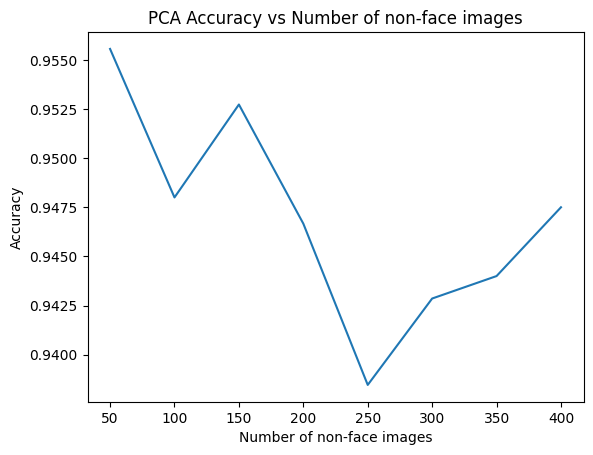

In [126]:
# plot accuracy vs number of non-face images
# pair[0] is the number of non-face images, pair[1] is the corresponding accuracy
plt.plot( [pair[0] for pair in pca_scores], [pair[1] for pair in pca_scores] )
plt.xlabel( 'Number of non-face images' )
plt.ylabel( 'Accuracy' )
plt.title( 'PCA Accuracy vs Number of non-face images' )
plt.show()

#### 3.2.3. Success and Failure Cases

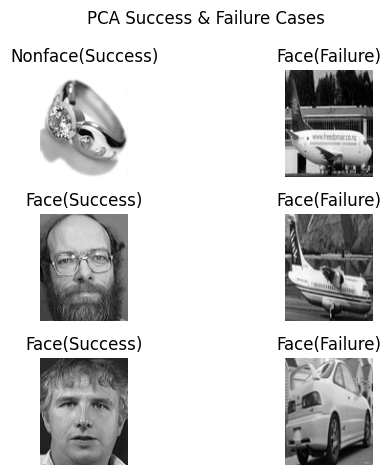

In [89]:
fig, axs = plt.subplots( 3, 2 )
success_count = 0
failure_count = 0

while success_count < 3 or failure_count < 3:

    # We randomly choose an image from the test set
    idx = np.random.randint( 0, len(test_set) - 1 )

    # We predict the label of the image
    prediction = knn.predict( new_test_set[idx].reshape( 1, -1 ) )

    # We plot 3 success cases and 3 failure cases. Success cases are on the left and failure cases are on the right
    if prediction == test_labels[idx]:
        if success_count == 3: continue
        i, j = success_count, 0
        success_count += 1

    elif failure_count < 3:
        i , j = failure_count, 1
        failure_count += 1
    
    else:
        continue

    axs[i, j].imshow( test_set[idx].reshape( 112, 92 ), cmap='gray' )
    axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if prediction != test_labels[idx] else '(Success)') )
    axs[i, j].axis( 'off' )

fig.suptitle( 'PCA Success & Failure Cases' )
fig.tight_layout()
plt.show()

## 4. Linear Discriminant Analysis

### 4.1. Prepping for LDA

#### 4.1.1. Function to return the new space with input training set

In [111]:
def LDA( training_set, h=False ):

    faces = training_set[ 0 : len(face_labels) // 2 ]
    nonfaces = training_set[ len(face_labels) // 2 : len(training_set) ]

    # Calculating the means of class-specific data (faces and non-faces)
    face_means = np.mean( faces, axis=0 )
    nonface_means = np.mean( nonfaces, axis=0 )

    # Reshaping to keep the dimensions consistent
    face_means = face_means.reshape( 1, 10304 )
    nonface_means = nonface_means.reshape( 1, 10304 )

    # Calculating the between-class scatter matrix
    B = np.dot( (face_means - nonface_means).T, (face_means - nonface_means) )

    # Centering the data
    centered_face_data = faces - face_means
    centered_nonface_data = nonfaces - nonface_means

    # Class scatter matrices
    Z1 = np.dot( centered_face_data.T, centered_face_data )
    Z2 = np.dot( centered_nonface_data.T, centered_nonface_data )

    # Calculating the within-class scatter matrix
    S = Z1 + Z2

    # Calculating the eigenvalues and eigenvectors of the covariance matrix of the training set
    # If h is True, we use the Hermitian version (eigh), otherwise we use the regular version (eig)
    if h == True:
        eigenvalues, eigenvectors = np.linalg.eigh( np.dot( np.linalg.inv(S), B ) )
    else:
        eigenvalues, eigenvectors = np.linalg.eig( np.dot( np.linalg.inv(S), B ) )

        eigenvalues = np.real( eigenvalues )
        eigenvectors = np.real( eigenvectors )

    # Sorting the eigenvectors in descending order of their corresponding eigenvalues
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvectors = ( eigenvectors[:, positions] )

    # Calculating the new space
    # Since we have 2 classes, we only need 1 dominant eigenvector
    new_space = sorted_eigenvectors[:, :1]

    return new_space

### 4.2. Classification using LDA

#### 4.2.1. Main Training Function for LDA

In [112]:
scores = []

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[LDA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )
    print( '----------------------------------------' )

    # Splitting the data into training and test sets according to the number of non-face images
    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    
    # Calculating the new space using LDA
    new_space = LDA( training_set, h=True )

    # Centering the training set and test set
    centered_training_set = training_set - np.mean( training_set, axis=0 )
    centered_test_set = test_set - np.mean( test_set, axis=0 )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space )
    new_test_set = np.dot( centered_test_set, new_space )

    # Fitting the KNN classifier to the training set
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( new_training_set, training_labels.ravel() )

    # Predicting the test set results
    score = knn.score( new_test_set, test_labels.ravel() )
    
    # Appending the score to the scores list for plotting later
    scores.append( score )

    print( '[LDA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%\n'.format(score * 100))

[LDA] Running for 50 non-face images
 25 -> training
 25 -> test
----------------------------------------
[LDA] Accuracy for 50 non-face images = 93.33%

[LDA] Running for 100 non-face images
 50 -> training
 50 -> test
----------------------------------------
[LDA] Accuracy for 100 non-face images = 84.40%

[LDA] Running for 150 non-face images
 75 -> training
 75 -> test
----------------------------------------
[LDA] Accuracy for 150 non-face images = 81.45%

[LDA] Running for 200 non-face images
 100 -> training
 100 -> test
----------------------------------------
[LDA] Accuracy for 200 non-face images = 83.33%

[LDA] Running for 250 non-face images
 125 -> training
 125 -> test
----------------------------------------
[LDA] Accuracy for 250 non-face images = 80.00%

[LDA] Running for 300 non-face images
 150 -> training
 150 -> test
----------------------------------------
[LDA] Accuracy for 300 non-face images = 78.57%

[LDA] Running for 350 non-face images
 175 -> training
 175 

#### 4.2.2. Plotting the results

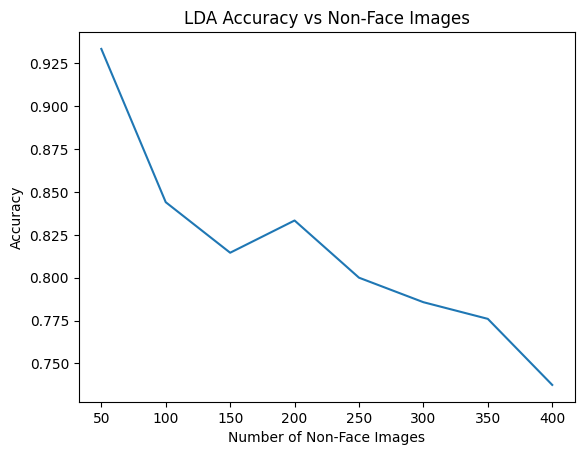

In [114]:
plt.plot( range( 50, len(nonface_data) + 1, 50 ), scores )
plt.xlabel( 'Number of Non-Face Images' )
plt.ylabel( 'Accuracy' )
plt.title( 'LDA Accuracy vs Non-Face Images' )
plt.show()

#### 4.2.3. Success and Failure Cases

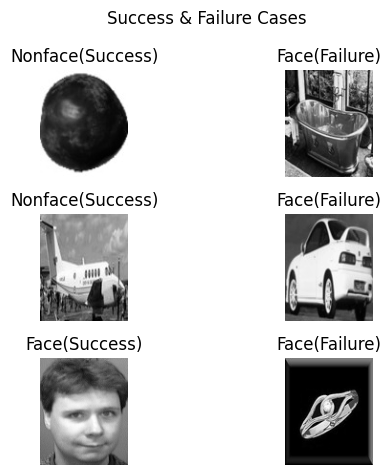

In [125]:
fig, axs = plt.subplots( 3, 2 )
success_count = 0
failure_count = 0

while success_count < 3 or failure_count < 3:

    # We randomly choose an image from the test set
    idx = np.random.randint( 0, len(test_set) - 1 )

    # We predict the label of the image
    prediction = knn.predict( new_test_set[idx].reshape( 1, -1 ) )

    # We plot 3 success cases and 3 failure cases. Success cases are on the left and failure cases are on the right
    if prediction == test_labels[idx]:
        if success_count == 3: continue
        i, j = success_count, 0
        success_count += 1

    elif failure_count < 3:
        i , j = failure_count, 1
        failure_count += 1
    
    else:
        continue

    axs[i, j].imshow( test_set[idx].reshape( 112, 92 ), cmap='gray' )
    axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if prediction != test_labels[idx] else '(Success)') )
    axs[i, j].axis( 'off' )

fig.suptitle( 'Success & Failure Cases' )
fig.tight_layout()
plt.show()